## Preprocessing

In [1]:
import numpy as np
import pandas as pd

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
%matplotlib inline

In [4]:
sns.set_style('darkgrid')

In [5]:
pd.options.display.float_format = '{:,.3f}'.format 

In [6]:
#loading unprocessed dataset
data = pd.read_csv('data.csv')

In [7]:
data.shape

(1848, 749)

In [8]:
data.head(2)

,A0_BloodTaken,A1a_City,A1b_random_sample,A10_age,A11_sex,A30_insurance,A16_witness_self,B1_greek_main_lang,B2_main_occupation,B6_father_occup,...,TMTratio,vfsem1stobj,vfsemobjrelated,vfsemobjcluste,vfsemobjswich,vfsemobjerr,vfsemobjpererr,vfphon1stalphobj,vfpharelated,DETERMINE_TOTAL
0,0.000,2,1.000,77.000,2.000,2.000,2.000,1.000,3.000,2.000,...,2.792,2.000,0.000,0.000,2.000,1.000,0.000,2.000,0.000,1
1,0.000,1,1.000,66.000,2.000,2.000,1.000,1.000,8.000,9.000,...,2.050,22.000,11.000,4.000,15.000,0.000,0.000,8.000,6.000,0


#### ΜΕΤΑΤΡΟΠΕΣ

In [9]:
#στη στηλη αυτη ειναι τα m που μπορει να περπατησει χωρις ξεκουραση, αλλα ειναι αντιστροφα.Θελει αποο 0->6 να ναι αυξουσα για να
#καταλαβει το μοντελο την ιεραρχια, ενω εδω ειναι φθινουσα, δλδ το 6 ειναι το 1m, και το 0 ειναι >1000m συνφωνα με το maelstrom
#Αρα αντικαθιστω.(αν και φαινεται το >1000m να ναι πιο πολλα λογω ηλικιων, αλλα ταιριαζει απτο dataset στα kg και τη περ.μεσης)
data['F24'].value_counts()

0.000    1453
3.000     114
1.000     111
2.000      92
4.000      48
5.000      22
0.519       5
6.000       3
Name: F24, dtype: int64

In [10]:
data['F24']

0      0.000
1      0.000
2      0.000
3      0.000
4      0.000
        ... 
1843   0.000
1844   0.000
1845   0.000
1846   0.000
1847   0.000
Name: F24, Length: 1848, dtype: float64

In [11]:
#για να αποφυγω να μου μετατρεψει λαθος το κανω σε δυο βηματα
data['F24'] = data['F24'].replace([0,1,2,3,4,5,6],[7,8,9,10,11,12,13])

In [12]:
data['F24'] = data['F24'].replace([7,8,9,10,11,12,13],[6,5,4,3,2,1,0])
data['F24'].value_counts()

6.000    1453
3.000     114
5.000     111
4.000      92
2.000      48
1.000      22
0.519       5
0.000       3
Name: F24, dtype: int64

#### μεταροπη των στηλων F29-F33 για να ταιριαζουν με το F26 που ειναι για απωλεια μνημης

In [13]:
data['F29'].value_counts()

0.097    1154
0.000     627
1.000      67
Name: F29, dtype: int64

In [14]:
#θελει πρωτα μετατροπη σε nan γτ αν τα κανω 0, μετα θα τα αλλαξει το replace
data['F29']= np.where(np.isclose(data['F29'].values, data['F29'].mean()), np.nan, data['F29'].values)
data['F30']= np.where(np.isclose(data['F30'].values, data['F30'].mean()), np.nan, data['F30'].values)
data['F31']= np.where(np.isclose(data['F31'].values, data['F31'].mean()), np.nan, data['F31'].values)
data['F33']= np.where(np.isclose(data['F33'].values, data['F33'].mean()), np.nan, data['F33'].values)

In [15]:
#αλλαζω F2->F33 για να ταιριαζουν με το F26 και να υπαρχει ιεραρχεια. Η F32 γινεται drop και μπαινει ως τιμη 0 στο F33
#τα δοκιμασα και δεν χρειαζεται να τα κανω σε 2 βηματα, ο αλγοριθμος τα σπαει!
data['F29'] = data['F29'].replace([1,0],[2,1])
data['F30'] = data['F30'].replace([0,1,2],[1,2,3])
data['F31'] = data['F31'].replace(0,2)
data['F33'] = data['F33'].replace([0,1,2,3,4],[1,2,3,4,5])


In [16]:
data['F29'] = data['F29'].replace(np.nan,0)
data['F30'] = data['F30'].replace(np.nan,0)
data['F31'] = data['F31'].replace(np.nan,0)
data['F33'] = data['F33'].replace(np.nan,0)

In [17]:
data['F29'].value_counts()

0.000    1154
1.000     627
2.000      67
Name: F29, dtype: int64

In [18]:
#μετατροπη στηλης προβλεψης
data['G1']= np.where(np.isclose(data['G1'].values, data['G1'].mean()), np.nan, data['G1'].values)
data['G1'] = data['G1'].replace([0,0.5,1,2,3,4,5],[0,1,2,3,4,5,6])                                

#### μετατροπη των στηλων βαρος, υψοσ, περιφερεια μεσης σε επιτρεπτες τιμες(εχω ελεγξει απ'το excel ποιες ειναι). Πρωτα ομως μετατρεπω το mean σε nan για να μη τα χασω μετα ως τιμες που λειπουν(γτ το mean θα αλλαξει ως αριθμος μετα τις αλλαγες)

In [19]:
data['HEIGHT'].isnull().values.sum()

0

In [20]:
#mean σε nan
data['HEIGHT']= np.where(np.isclose(data['HEIGHT'].values, data['HEIGHT'].mean()), np.nan, data['HEIGHT'].values)
data['WEIGHT']= np.where(np.isclose(data['WEIGHT'].values, data['WEIGHT'].mean()), np.nan, data['WEIGHT'].values)
data['WAISTCIRCUMFERENCE']= np.where(np.isclose(data['WAISTCIRCUMFERENCE'].values, data['WAISTCIRCUMFERENCE'].mean()),
                                     np.nan, data['WAISTCIRCUMFERENCE'].values)

In [21]:
data['HEIGHT']= np.where(data['HEIGHT']<105, np.nan, data['HEIGHT'].values)
data['WEIGHT']= np.where(data['WEIGHT']<42, np.nan, data['WEIGHT'].values)
data['WAISTCIRCUMFERENCE']= np.where(data['WAISTCIRCUMFERENCE']>160, np.nan, data['WAISTCIRCUMFERENCE'].values)
data['WAISTCIRCUMFERENCE']= np.where(data['WAISTCIRCUMFERENCE']<53, np.nan, data['WAISTCIRCUMFERENCE'].values)

#### ελεγχω οτι η στηλη ωρες υπνου/μερα,ειναι σε επιτρεπτες τιμες >1h & <24h

In [22]:
data['hAPAQ10'].isnull().values.sum()

0

In [23]:
data['hAPAQ10']= np.where(np.isclose(data['hAPAQ10'].values, data['hAPAQ10'].mean()), np.nan, data['hAPAQ10'].values)
data['hAPAQ10']= np.where(data['hAPAQ10']<2, np.nan, data['hAPAQ10'].values)
data['hAPAQ10']= np.where(data['hAPAQ10']>24, np.nan, data['hAPAQ10'].values) 

#### ΜΕΤΑΤΡΟΠΗ DETERMINE

#### Οι στηλες με τις ερωτησεις του DETERMINE δεν εχουν την βαθμολογια που οριζεται στα αρθρα αλλα δυαδικη τιμη 0, 1 για οχι, ναι. Μετατρεπω αρχικα, σε καθε στηλη το 1 στο σκορ που της αντιστοιχει (αφου πρωτα εχω κανει nan τα mean). Στο τελος, αφου εχω δει και πως θα καλληφθουν τα nan σ' ολο το dataser, φτιαχνω στηλη που θα αντιστοιχει στο τελικο σκορ ως αθροισμα των επι μερους στηλων. (Δε ξερω τι γινεται στα nan που ειναι σε καποιες στηλες, αν απλα δεν προσμετρωνται )

In [24]:
#mean to nan
data['DETERMINE1']= np.where(np.isclose(data['DETERMINE1'].values, data['DETERMINE1'].mean()), np.nan, data['DETERMINE1'].values)
data['DETERMINE3']= np.where(np.isclose(data['DETERMINE3'].values, data['DETERMINE3'].mean()), np.nan, data['DETERMINE3'].values)
data['DETERMINE4']= np.where(np.isclose(data['DETERMINE4'].values, data['DETERMINE4'].mean()), np.nan, data['DETERMINE4'].values)
data['DETERMINE5']= np.where(np.isclose(data['DETERMINE5'].values, data['DETERMINE5'].mean()), np.nan, data['DETERMINE5'].values)
data['DETERMINE6']= np.where(np.isclose(data['DETERMINE6'].values, data['DETERMINE6'].mean()), np.nan, data['DETERMINE6'].values)
data['DETERMINE7']= np.where(np.isclose(data['DETERMINE7'].values, data['DETERMINE7'].mean()), np.nan, data['DETERMINE7'].values)
data['DETERMINE8']= np.where(np.isclose(data['DETERMINE8'].values, data['DETERMINE8'].mean()), np.nan, data['DETERMINE8'].values)
data['DETERMINE9']= np.where(np.isclose(data['DETERMINE9'].values, data['DETERMINE9'].mean()), np.nan, data['DETERMINE9'].values)
data['DETERMINE10']= (np.where(np.isclose(data['DETERMINE10'].values, data['DETERMINE10'].mean()), np.nan, 
                               data['DETERMINE10'].values))

In [25]:
#αντικατασταση σκορ καθε στηλης μ' αυτο του αρθρου
data['DETERMINE1'] = data['DETERMINE1'].replace(1,2)
data['DETERMINE2'] = data['DETERMINE2'].replace(1,3)
data['DETERMINE3'] = data['DETERMINE3'].replace(1,2)
data['DETERMINE4'] = data['DETERMINE4'].replace(1,2)
data['DETERMINE5'] = data['DETERMINE5'].replace(1,2)
data['DETERMINE6'] = data['DETERMINE6'].replace(1,4)
data['DETERMINE9'] = data['DETERMINE9'].replace(1,2)

In [26]:
#νεα στηλη για ολικο σκορ του DETERMINE
data['determine_sum'] = (data['DETERMINE1']+data['DETERMINE2']+data['DETERMINE3']+data['DETERMINE4']+
                         data['DETERMINE5']+data['DETERMINE6']+data['DETERMINE7']+data['DETERMINE8']+
                         data['DETERMINE9']+data['DETERMINE10'])

In [27]:
#Νεα στηλη για το ΒΜΙ αφου εχουν γινει ολες οι αλλαγες στο dataset
data['calculate_bmi'] = (data['WEIGHT']/((data['HEIGHT']/100)**2))# /100 γιατι το υψος ειναι σε cm
data['calculate_bmi'].apply(lambda x: float(x)) #απαραιτητο 

0         nan
1      20.571
2      34.964
3         nan
4      34.850
        ...  
1843   27.055
1844   34.291
1845   29.408
1846      nan
1847   25.156
Name: calculate_bmi, Length: 1848, dtype: float64

### μετατροπες με κωδικους που εχω βαλει στο excel

In [28]:
# Για να μπορεσω να διαβασω το excel που εχω φτιαξει με τα ονοματα και τη κωδικοποιηση απτο τι θα κανω τις στηλες
#Εχω επισης αλλαξει στα region settings του pc το " ," γτ ηταν ΄"΄΄;"

#encoding = "ISO-8859-7"  για ελληνικα γτ το utf-8 δεν δουλευει"
process_codes = pd.read_excel('data_xl.xlsx',sheet_name='clmn_names',encoding = "ISO-8859-7")
print(process_codes.shape)
process_codes.head()

(3, 749)


,A0_BloodTaken,A1a_City,A1b_random_sample,A10_age,A11_sex,A30_insurance,A16_witness_self,B1_greek_main_lang,B2_main_occupation,B6_father_occup,...,TMTratio,vfsem1stobj,vfsemobjrelated,vfsemobjcluste,vfsemobjswich,vfsemobjerr,vfsemobjpererr,vfphon1stalphobj,vfpharelated,DETERMINE_TOTAL
0,drop,drop,drop,NaN,ohe,ohe,zerovar,zerovar,ohe,ohe,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,drop
1,Blood sample,City of examination,Random sample,Age,Gender,Insurance,Person providing the information,Participant's spoken language,Occupation when working,Father's occupation,...,TMT ratio (B: Α),Semantic objects,Semantic objects related words,Semantic objects cluster,Semantic objects switches,Semantic objects error,Semantic objects perseverations,"Phonological letter ""a""","Phonological letter ""a"" related",NaN
2,NaN,1=larisa 2=marous,NaN,NaN,1=male 2=female,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [29]:
#process_codes.drop(axis=0,index=2,inplace=True) # αφαιρω γραμμες με σχολια μου

In [30]:
#ενωνω τα δυο df για να εχω τις γραμμες με την εξηγηση και το κωδικο μορφοποιησης
#data = pd.concat([process_codes,data],ignore_index=True)

#### αποθηκευω σε λιστες για μετα, τα ονοματα των στηλων που εχω αποφασισει manually να κανω drop, mean to zero, near-zero variance, gender specific (και one hot encoding, ισως χρειαστει)

In [31]:
#αποθηκευω σε λιστα τις στηλες που θελω να κανω drop
drop_list = list(process_codes.columns[(process_codes=='drop').iloc[0]])
print(drop_list,len(drop_list))

#ERROR
#If code or library is using the in or == operators to compare python string to numpy ndarrays, they aren't compatible, 
#so when you try it, it returns a scalar, but only for now. The Warning indicates that in the future this behavior might change
#if python/numpy decide to do adopt Numpy style

['A0_BloodTaken', 'A1a_City', 'A1b_random_sample', 'B13a_married', 'B13k_kids_abroad', 'B13l_kids_in_distance', 'B14b_residence_rent', 'B14d_residence_rooms', 'B17_summer_holidays', 'B17b_holidays_location', 'B17c_holidays_abroad', 'C15b_LOC_duration', 'C26c_mensturation_duration', 'C30_age_start_smoking', 'C31_age_stop_smoking', 'C45_social_drinker_self', 'C46_social_drinker_others', 'C50m_stroke_in_hospital', 'D1_father_alive', 'D4_mother_alive', 'D5b_siblings_has_history', 'D29_num_children', 'D29b_children_has_history', 'F17', 'F19', 'F32', 'L46', 'L47', 'L48', 'I12', 'BMI', 'BMI_calcul', 'hAPAQ7', 'hAPAQ17b', 'hAPAQ19', 'Readletters1', 'Readwords1', 'Readingsyllables1', 'Read_matchsentence', 'clockcopy', 'DETERMINE_TOTAL'] 41


In [32]:
#αποθηκευω σε λιστα τις στηλες οπου το mean πρεπει να γινει 0
tozero_list = list(process_codes.columns[(process_codes=='tozero').iloc[0]])
print(tozero_list,len(tozero_list))

['B13f_widower_years', 'B13m_num_kids_away', 'B17a_holidays_days', 'C29_cigars_daily', 'C32_years_smoker', 'C50i_stroke_sudden', 'C50j_stroke_duration', 'C50k_stroke_recovery', 'C50n_stroke_hospital_duration', 'C50o_stroke_treatment', 'D2b_father_died_at_age_of', 'D4b_mother_died_at_age_of'] 12


In [33]:
#αποθηκευω σε λιστα τις στηλες near-zero variance
zerovar_list = list(process_codes.columns[(process_codes=='zerovar').iloc[0]])
print(zerovar_list,len(zerovar_list))

['A16_witness_self', 'B1_greek_main_lang', 'C14_doping', 'C22_normal_pressure_hydrocephalus', 'C47_drink_alone', 'C48_drink_morning', 'D3b_parent_history_other', 'D6b_mother_history_other', 'D5d_siblings_history_b', 'D5e_siblings_history_c', 'J24a', 'J24b', 'J24c', 'J25', 'J32', 'J32d', 'J32e', 'J32f', 'J32g', 'J32i', 'J32j', 'J33', 'J33d', 'J33e', 'J33f', 'J34', 'J34d', 'J34e', 'J34f', 'J34h', 'J34i', 'J34j', 'J35', 'J35d', 'J35e', 'J35f', 'J35g', 'J35h', 'J35i', 'J35j', 'J36', 'J36d', 'J36e', 'J36f', 'J36g', 'J36h', 'J36i', 'J37', 'J37d', 'J37e', 'J37f', 'J37g', 'J37h', 'J37i', 'J38', 'J38d', 'J38e', 'J38f', 'J38g', 'J38h', 'J38i', 'J38j', 'J39', 'J39d', 'J39e', 'J39h', 'J39i', 'J40', 'J40d', 'J40f', 'J40g', 'J40h', 'J41', 'J41d', 'J41e', 'J41f', 'J41g', 'J41h', 'J41i', 'J42', 'J42d', 'J42e', 'J42f', 'J42g', 'J42i', 'J42j', 'J43', 'J42d_A', 'J42e_A', 'J42f_A', 'J42g_A', 'J42h_A', 'J42i_A', 'K1', 'K2', 'K4', 'K10', 'K13', 'K42', 'K43', 'K44', 'K45', 'I1a', 'I1b', 'I4', 'I4a', 'I4b', '

In [34]:
#αποθηκευω σε λιστα τις στηλες που ειναι ειδικες για το φυλλο gs=gender specific
gs_list = list(process_codes.columns[(process_codes=='gs').iloc[0]])
print(gs_list,len(gs_list))

['C26a_mensturation_start', 'C26b_mensturation_stop', 'C26d_mensturation_normal', 'C26e_pregnancies', 'C26g_abortions', 'C26h_abortions_provoked'] 6


In [35]:
#αποθηκευω σε λιστα τις στηλες για one hot encoding
ohe_list = list(process_codes.columns[(process_codes=='ohe').iloc[0]])
print(ohe_list,len(ohe_list))

['A11_sex', 'A30_insurance', 'B2_main_occupation', 'B6_father_occup', 'B7_mother_occup', 'D3a_parent_history', 'hAPAQ21'] 7


#### Αφαιρω τις στηλες συμφωνα με τους κωδικους που εχω βαλει 

In [36]:
data.drop(drop_list,axis=1,inplace=True)
#data.drop(zerovar_list,axis=1,inplace=True)
data.drop(gs_list,axis=1,inplace=True)

In [37]:
data.shape

(1848, 704)

#### Mean Το Zero στις αντιστοιχες στηλες.(Καποιες σειρες που  κανονικα εχουν τιμες που λειπουν και θα επρεπε να γινουν nan, θa γινουν τωρα, λανθασμενα 0, αλλα αυτο δε μπορει να αποφευχθει με αλλο τροπο)

In [38]:
for i in tozero_list:
    data[i]=np.where(np.isclose(data[i].values, data[i].mean()), 0, data[i].values)

In [39]:
#βλεπω πως πετυχε
data['C50i_stroke_sudden'].value_counts()

0.000    1725
1.000     123
Name: C50i_stroke_sudden, dtype: int64

In [40]:
data.shape

(1848, 704)

#### One hot encoding πρεπει να γινει στο training data απ οτι ειδα, αρα στο τελοσ ολων των διεργασιων του preprocessing,   ειτε με Keras ειτε sklearn https://machinelearningmastery.com/how-to-one-hot-encode-sequence-data-in-python/

In [41]:
#from sklearn.compose import ColumnTransformer
#from sklearn.preprocessing import OneHotEncoder

#ct = ColumnTransformer(transformers=[('encoder',OneHotEncoder(),['A11_sex'])], remainder='passthrough')

#ohe_data = np.array(ct.fit_transform(data))
#εδω αναγκαζουμε να μας επιστρεψει np array το οποιο ειναι κι αυτο που ζητανε τα μοντελα μας, γτ κανονικα επιστρεφει ndarray.
#Αρα προσοχη τι οριζουμε ως τελικο που θα μας επιστρεψει για να μη χασουμε το dataframe. Επισης, δε δεχεται τη λιστα απο τα 
#ονοματα των στηλων ως παραμετρο στο transformers, αρα πρεπει καπως αλλιως να οριστουν αυτα

## Handle nans

Number of null values in dataset:  1848
Percentage:  0.14204545454545456


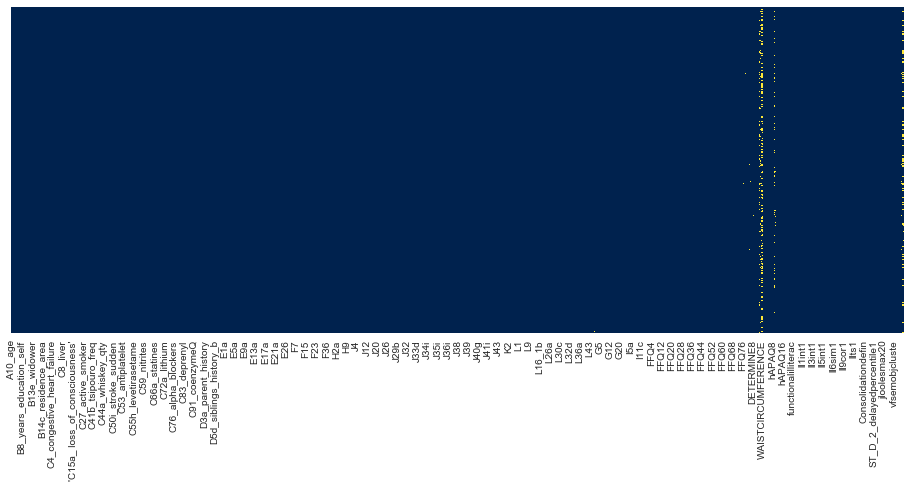

In [42]:
#βλεπω το ποσοστο των null αμεσως μετα τις μετατροπες, ενω δεν εχω αλλαξει τα mean

print("Number of null values in dataset: ",data.isnull().values.sum()) #αριθμος
print("Percentage: ",(data.isnull().sum().sum()/data.size)*100) #ποσοστο

plt.figure(figsize=(16,6))
sns.heatmap(data.isnull(),yticklabels=False,cbar=False,cmap='cividis')

Number of null values in dataset:  76205
Percentage:  5.8574533894136165


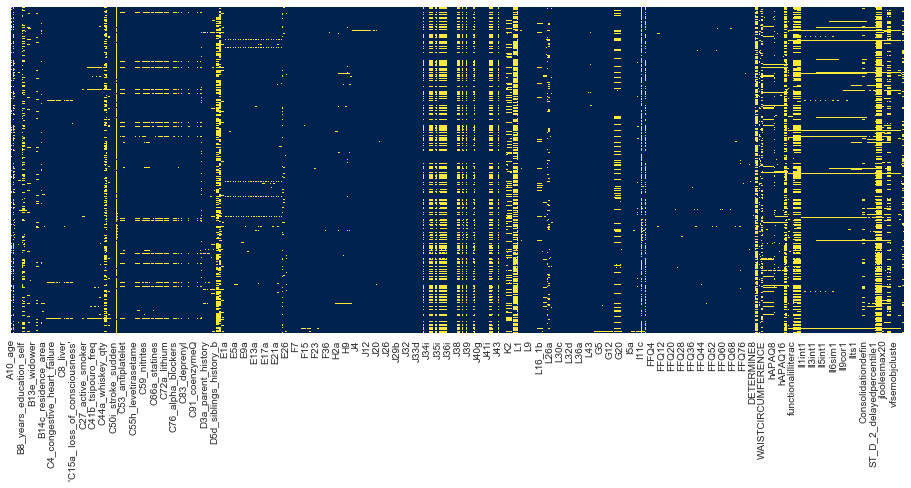

In [43]:
#μετατρεπω τα mean σε null 
for column in data:
        data[column] = np.where(np.isclose(data[column].values, data[column].mean()), np.nan, data[column].values)
        
print("Number of null values in dataset: ",data.isnull().values.sum()) #αριθμος
print("Percentage: ",(data.isnull().sum().sum()/data.size)*100) #ποσοστο

plt.figure(figsize=(16,6))
sns.heatmap(data.isnull(),yticklabels=False,cbar=False,cmap='cividis')

In [44]:
#λιστα με τις στηλες με αριθμο null σε φθινουσα σειρα
desc = data.isnull().sum(axis=0)
desc.sort_values(ascending=False,inplace=True)
print(desc[:20])

C50l_stroke_diplopia         1719
K45                          1426
figurerecognitionSUM         1408
ST_E_1_figurerecfalsepos     1408
ST_E_1_figurerectruepos      1408
ST_E_1_figurerectrueneg      1408
ST_E_1_figurerecfalseneg     1408
I11d                         1251
DENTAL_PLATE_FOOD            1243
hAPAQ20                      1239
DENTAL_PLATE                 1219
K44                          1185
K43                          1184
K42                          1184
D9a_min_sibling_death_age    1143
D9a_max_sibling_death_age    1143
hAPAQ18                      1104
D9f_min_sibling_alive_age    1035
D9f_max_sibling_alive_age    1035
MonthsBerr                   1003
dtype: int64


In [45]:
#αποθηκευω το data στη df s αφου εχω αφαιρεσει τις στηλες με ~ 30% null που ειναι το rule of thumb(thresh == αριθμος μη null !!)
s= pd.DataFrame(data.dropna(axis='columns',thresh=(len(data)*0.7)))

In [46]:
#αποφευγω να αφαιρεσω γραμμες γτ θα χασω πολλες εγγραφες και γενικα δε συνισταται
#s.dropna(axis='index',thresh=(len(s.columns)*0.98)).shape

Number of null values in dataset:  23480
Percentage:  1.9517093249812143
Dataset shape :  (1848, 651)


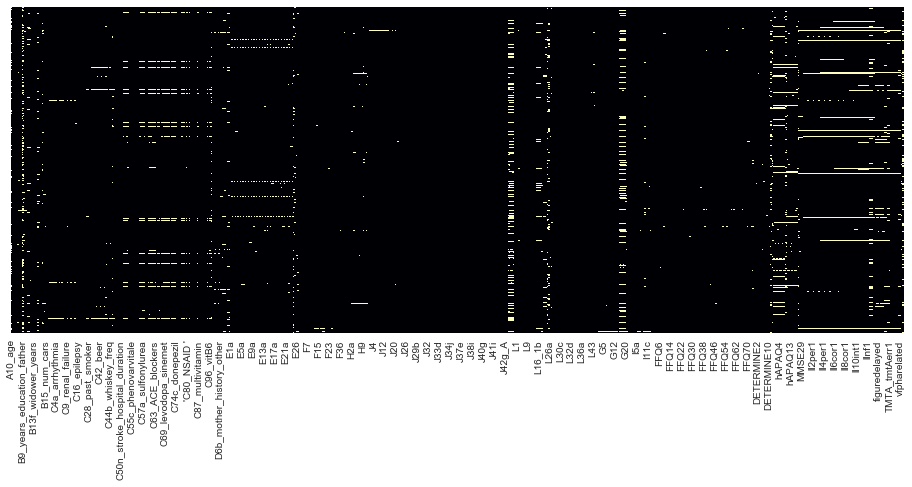

In [47]:
#τελικο προϊον απο την αφαιρεση των null
print("Number of null values in dataset: ",s.isnull().values.sum()) #αριθμος
print("Percentage: ",(s.isnull().sum().sum()/s.size)*100) #ποσοστο
print("Dataset shape : ",s.shape)

plt.figure(figsize=(16,6))
sns.heatmap(s.isnull(),yticklabels=False,cbar=False,cmap='magma')

In [ ]:
#### τελικη μετατροπη στηλων προβλεψης (αφαιρεση nan)

In [48]:
print(s['G1'].isnull().values.sum(),s['G21'].isnull().values.sum())
s['G1'].fillna(0,inplace=True)
s['G21'].fillna(0,inplace=True)
print(s['G1'].isnull().values.sum(),s['G21'].isnull().values.sum())

3 10
0 0


In [55]:
#αποθηκευω σε αρχειο csv, χωρις να ξαναφτιαχνω index
s.to_csv(r'C:\Users\redi\Desktop\Βαρλαμης\data\data_prep.csv',index=False)
print("Shape of dataset : ",s.shape)

Shape of dataset :  (1848, 651)


#### αφαιρω near zero variance και αποθηκευω ξεχωριστα

In [50]:
b = pd.DataFrame(data.drop(zerovar_list,axis=1))
b.dropna(axis='columns',thresh=(len(b)*0.7),inplace=True)
print("Shape of dataset : ",b.shape)

Shape of dataset :  (1848, 567)


In [51]:
print(b['G1'].isnull().values.sum(),b['G21'].isnull().values.sum())
b['G1'].fillna(0,inplace=True)
b['G21'].fillna(0,inplace=True)
print(b['G1'].isnull().values.sum(),b['G21'].isnull().values.sum())

3 10
0 0


In [54]:
b.to_csv(r'C:\Users\redi\Desktop\Βαρλαμης\data\data_prep_no_zv.csv',index=False)